In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sac
import pylab as plt
from importlib import reload
import torch 
import time

import laserhockey.hockey_env as h_env


Using device: cpu


In [3]:
env_name = "Pendulum-v1"
#env_name = "LunarLander-v2"
log_interval = 20         # print avg reward in the interval
max_episodes = 100 # max training episodes
max_timesteps = 2000         # max timesteps in one episode
save_interval = 100
train_iter = 32      # update networks for given batched after every episode
random_seed = 42

In [18]:
def save_statistics(rewards,lengths,q_losses,pi_losses,temperature_loss,env_name,random_seed,episode):
    with open(f"./results/SAC_{env_name}-s{random_seed}-e{episode}-stat.pkl", 'wb') as f:
        pickle.dump({"rewards" : rewards, "lengths": lengths, "train": train_iter,
                        "pi_losses": pi_losses, "q_losses": q_losses,
                        "temperature_loss":temperature_loss}, f)

In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)    

In [6]:
def run_sac_agent_in_environment(env_name=env_name,log_interval=log_interval,save_interval=save_interval,max_episodes=max_episodes,max_timesteps=max_timesteps,train_iter=train_iter,random_seed=random_seed):
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    env = gym.make(env_name)

    if env_name == "LunarLander-v2":
        env = gym.make(env_name,continuous=True)
    else:
        env = gym.make(env_name)
    agent = sac.SAC_Agent(env.observation_space, env.action_space)
    rewards = []
    lengths = []
    q_losses = []
    policy_losses = []
    temperature_losses = []
    timestep = 0
    training_steps = 0

    for episode in range(1,max_episodes+1):
        ob, _info = env.reset()
        total_reward=0
        for t in range(max_timesteps):
            timestep +=1
            done = False
            a = agent.act(ob)
            (ob_new,reward,done,trunc,_info) = env.step(a)
            total_reward += reward
            agent.store_transition((ob,a,reward,ob_new,done))
            ob=ob_new
            if done or trunc: break

        q_loss,pi_loss,temperature_loss = agent.train(train_iter)
        training_steps +=1
        
            
        q_losses.extend(q_loss)
        policy_losses.extend(pi_loss)
        temperature_losses.extend(temperature_loss)
        rewards.append(total_reward)
        lengths.append(t)

        if episode % save_interval == 0:
            print("########### Save checkpoint ################")
            torch.save(agent.get_networks_states(),f'./results/SAC_{env_name}-e{episode}-t{train_iter}-s{random_seed}.pth')
            save_statistics(rewards,lengths,q_losses,policy_losses,temperature_losses,env_name,random_seed,episode)

        if episode % log_interval == 0:
            avg_reward = np.mean(rewards[-log_interval:])
            avg_length = int(np.mean(lengths[-log_interval:]))
            print('Episode {} \t avg length: {} \t reward: {}'.format(episode, avg_length, avg_reward))
    save_statistics(rewards,lengths,q_losses,policy_losses,temperature_losses,env_name,random_seed,episode)
    
    print(training_steps)

In [7]:
run_sac_agent_in_environment(env_name=env_name,log_interval=log_interval,save_interval=save_interval,max_episodes=max_episodes,max_timesteps=max_timesteps,train_iter=train_iter,random_seed=random_seed)

Episode 20 	 avg length: 199 	 reward: -1237.3815268023016
Episode 40 	 avg length: 199 	 reward: -1215.64701074413


KeyboardInterrupt: 

## Helper Functions

In [6]:
def run(env, agent, n_episodes=100):
    rewards = []
    observations = []
    actions = []
    agent.eval
    for ep in range(1, n_episodes+1):
        ep_reward = 0
        state, _info = env.reset()
        for t in range(2000):
            action = agent.act(state)
            state, reward, done, _trunc, _info = env.step(action)
            observations.append(state)
            actions.append(action)
            ep_reward += reward
            if done or _trunc:
                break
        rewards.append(ep_reward)
        ep_reward = 0
    print(f'Mean reward: {np.mean(rewards)}')
    observations = np.asarray(observations)
    actions = np.asarray(actions)
    return observations, actions, rewards

# SAC

In [7]:
with open(f"./results/SAC_{env_name}-s{random_seed}-e{max_episodes}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    q_losses =  np.asarray(data["q_losses"])
    pi_losses  = np.asarray(data["pi_losses"])
    temperature_losses = np.asarray(data["temperature_loss"])

In [8]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(q_losses,10),label=f"Q loss")
plt.plot(running_mean(pi_losses,10),label=f"Pi loss")
#plt.plot(running_mean(temperature_losses,10),label=f"Temp loss")
plt.legend()
plt.savefig(f"/results/env_{env_name}_episode_{max_episodes}.jpg")

: 

: 

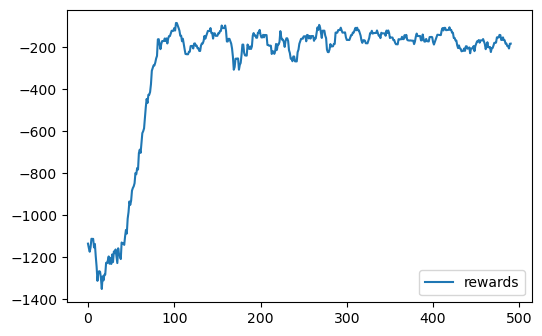

In [ ]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10),label=f"rewards")
plt.legend()

## value function

In [ ]:
def plot_Q_function(q_function, observations, actions, plot_dim1=0, plot_dim2=2,
                    label_dim1="cos(angle)", label_dim2="angular velocity"):
    plt.rcParams.update({'font.size': 12})
    observations_tensor = torch.from_numpy(observations)
    actions_tensor = torch.from_numpy(actions)
    values =q_function.get_min_Q_value(observations_tensor,actions_tensor).detach().numpy()
    
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot()
    surf = ax.scatter (observations[:,plot_dim1], observations[:,plot_dim2],  c = values, cmap=cm.coolwarm)
    ax.set_xlabel(label_dim1)
    ax.set_ylabel(label_dim2)

    return fig

In [ ]:
env = gym.make(env_name)

In [ ]:
checkpoint = f"./results/SAC_{env_name}-e{int(max_episodes/save_interval)*save_interval}-t{train_iter}-s{random_seed}.pth"
print(checkpoint)

./results/SAC_Pendulum-v1-e500-t32-s42.pth


In [ ]:
agent  = sac.SAC_Agent(env.observation_space, env.action_space)
#print(torch.load(checkpoint)[1])
agent.load_network_states(torch.load(checkpoint))
agent.eval()

Agent now in evaluation Mode


In [ ]:
observations, actions, rewards = run(env,agent,100)

Mean reward: -162.0929076632593


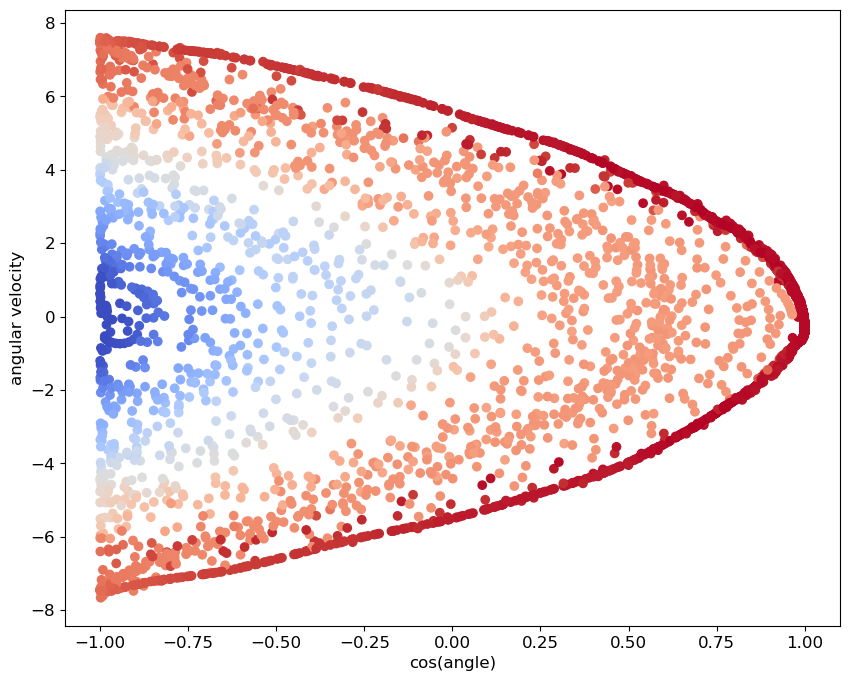

In [ ]:
_ = plot_Q_function(agent.critic,observations,actions)

In [ ]:
env = gym.make(env_name, render_mode="human")
agent = sac.SAC_Agent(env.observation_space, env.action_space)
agent.load_network_states(torch.load(checkpoint))
agent.eval()
#TODO implement agent working in environment
observation, info = env.reset(seed=42)
for _ in range(500):
   action = agent.act(observation)
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

Agent now in evaluation Mode


In [ ]:
env.close()

## HalfCheetah

In [ ]:
env_name = "HalfCheetah-v4"
log_interval = 20         # print avg reward in the interval
max_episodes = 1000 # max training episodes
max_timesteps = 2000         # max timesteps in one episode
save_interval = 500
train_iter = 32      # update networks for given batched after every episode
random_seed = 42

In [ ]:
run_sac_agent_in_environment(env_name=env_name,log_interval=log_interval,save_interval=save_interval,max_episodes=max_episodes,max_timesteps=max_timesteps,train_iter=train_iter,random_seed=random_seed)

Episode 20 	 avg length: 999 	 reward: -272.38444782535896
Episode 40 	 avg length: 999 	 reward: -190.84884611241836
Episode 60 	 avg length: 999 	 reward: -153.5050058591753
Episode 80 	 avg length: 999 	 reward: -159.26660119306754
Episode 100 	 avg length: 999 	 reward: -172.82806855706653
Episode 120 	 avg length: 999 	 reward: -128.8818606048621
Episode 140 	 avg length: 999 	 reward: -108.73566002838393
Episode 160 	 avg length: 999 	 reward: 36.63573489217483
Episode 180 	 avg length: 999 	 reward: 177.7017892214564
Episode 200 	 avg length: 999 	 reward: 289.6553204891874
Episode 220 	 avg length: 999 	 reward: 454.5081001114404
Episode 240 	 avg length: 999 	 reward: 525.5372036251363
Episode 260 	 avg length: 999 	 reward: 632.5617867001166
Episode 280 	 avg length: 999 	 reward: 658.094436694182
Episode 300 	 avg length: 999 	 reward: 747.510866017944
Episode 320 	 avg length: 999 	 reward: 855.1660567565943
Episode 340 	 avg length: 999 	 reward: 990.2068519473462
Episode 

RuntimeError: Parent directory ./results does not exist.

In [ ]:
with open(f"./results/SAC_{env_name}-s{random_seed}-e{int(max_episodes/save_interval)*save_interval}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    q_losses =  np.asarray(data["q_losses"])
    pi_losses  = np.asarray(data["pi_losses"])
    temperature_losses = np.asarray(data["temperature_loss"])

NameError: name 'pickle' is not defined

In [ ]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10))

: 

: 

In [ ]:
checkpoint = f"./SAC_{env_name}-e{int(3000)*save_interval}-t{train_iter}-s{random_seed}.pth"
env = gym.make(env_name, render_mode="human")
agent = sac.SAC_Agent(env.observation_space, env.action_space)
agent.eval()
#TODO implement agent working in environment
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = agent.act(observation)
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

Agent now in evaluation Mode


In [ ]:
env.close()

## Lunar Lander

In [ ]:
#env_name = "Pendulum-v1"
env_name = "LunarLander-v2"
log_interval = 20         # print avg reward in the interval
max_episodes = 3000 # max training episodes
max_timesteps = 2000         # max timesteps in one episode
save_interval = 500
train_iter = 32      # update networks for given batched after every episode
random_seed = 42

In [ ]:
run_sac_agent_in_environment(env_name=env_name,log_interval=log_interval,save_interval=save_interval,max_episodes=max_episodes,max_timesteps=max_timesteps,train_iter=train_iter,random_seed=random_seed)

Episode 20 	 avg length: 103 	 reward: -199.20054407225672
Episode 40 	 avg length: 121 	 reward: -242.2360819145713
Episode 60 	 avg length: 97 	 reward: -236.80724120442977
Episode 80 	 avg length: 102 	 reward: -248.72293966982738
Episode 100 	 avg length: 96 	 reward: -300.85255615006383
Episode 120 	 avg length: 487 	 reward: -60.08536165903977
Episode 140 	 avg length: 998 	 reward: -37.272858777341874
Episode 160 	 avg length: 999 	 reward: -29.67047538498513
Episode 180 	 avg length: 999 	 reward: -53.795686905580204
Episode 200 	 avg length: 999 	 reward: -60.64358436860023
Episode 220 	 avg length: 999 	 reward: -72.35108625736768
Episode 240 	 avg length: 999 	 reward: -63.138739285515975
Episode 260 	 avg length: 990 	 reward: -59.67527445776879
Episode 280 	 avg length: 914 	 reward: -84.09463550943016
Episode 300 	 avg length: 932 	 reward: -220.47942269342266
Episode 320 	 avg length: 955 	 reward: -21.269212179001833
Episode 340 	 avg length: 999 	 reward: 11.3691697952

In [ ]:
with open(f"./results/SAC_{env_name}-s{random_seed}-e{int(max_episodes/save_interval)*save_interval}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    q_losses =  np.asarray(data["q_losses"])
    pi_losses  = np.asarray(data["pi_losses"])
    temperature_losses = np.asarray(data["temperature_loss"])

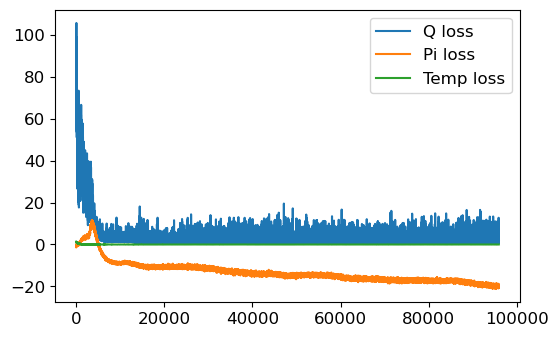

In [ ]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(q_losses,10),label=f"Q loss")
plt.plot(running_mean(pi_losses,10),label=f"Pi loss")
plt.plot(running_mean(temperature_losses,10),label=f"Temp loss")
plt.legend()

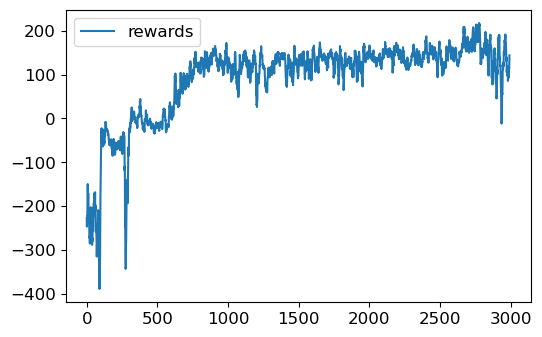

In [ ]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10),label=f"rewards")
plt.legend()

In [ ]:
checkpoint = f"./results/SAC_{env_name}-e{int(max_episodes/save_interval)*save_interval}-t{train_iter}-s{random_seed}.pth" 
env = gym.make(env_name, render_mode="human",continuous=True)
agent = sac.SAC_Agent(env.observation_space, env.action_space)
agent.load_network_states(torch.load(checkpoint))
agent.eval()
#TODO implement agent working in environment
observation, info = env.reset(seed=4)
for _ in range(1200):
   action = agent.act(observation)
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

In [ ]:
env.close()

### Mountain Car Continuous

In [ ]:
env_name = "MountainCarContinuous-v0"
log_interval = 20         # print avg reward in the interval
max_episodes = 1000 # max training episodes
max_timesteps = 2000         # max timesteps in one episode
save_interval = 1000
train_iter = 32      # update networks for given batched after every episode
random_seed = 42

In [ ]:
run_sac_agent_in_environment(env_name=env_name,log_interval=log_interval,save_interval=save_interval,max_episodes=max_episodes,max_timesteps=max_timesteps,train_iter=train_iter,random_seed=random_seed)

In [ ]:
with open(f"./results/SAC_{env_name}-s{random_seed}-e{int(max_episodes/save_interval)*save_interval}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    q_losses =  np.asarray(data["q_losses"])
    pi_losses  = np.asarray(data["pi_losses"])
    temperature_losses = np.asarray(data["temperature_loss"])

In [ ]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(q_losses,10),label=f"Q loss")
plt.plot(running_mean(pi_losses,10),label=f"Pi loss")
plt.plot(running_mean(temperature_losses,10),label=f"Temp loss")
plt.legend()

In [ ]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10),label=f"rewards")
plt.legend()

In [ ]:
checkpoint = f"./results/SAC_{env_name}-e{int(max_episodes/save_interval)*save_interval}-t{train_iter}-s{random_seed}.pth"
env = gym.make(env_name, render_mode="human")
agent = sac.SAC_Agent(env.observation_space, env.action_space)
agent.load_network_states(torch.load(checkpoint))
agent.eval()
#TODO implement agent working in environment
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = agent.act(observation)
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

In [ ]:
env.close()

Hockey

In [3]:
def reward_shaping(reward,info,opponent=False):
    if opponent:
        reward *= -1
    return reward

In [15]:
def run_sac_agent_in_environment(env_name,log_interval,save_interval,max_episodes,max_timesteps,train_iter,
                                 random_seed,show_training=False):
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    if env_name == "Defense":
        env = h_env.HockeyEnv.TRAIN_DEFENSE
    elif env_name == "Attack":
        env = h_env.HockeyEnv.TRAIN_SHOOTING
    elif env_name == "Easy":
        env = h_env.HockeyEnv()
        opponent = h_env.BasicOpponent(weak=True)
    elif env_name == "Hard":
        env = h_env.HockeyEnv()
        opponent = h_env.BasicOpponent(weak=False)
    else:
        env = h_env.HockeyEnv()
        opponent = sac.SAC_Agent(env.observation_space,env.action_space)
    
    agent = sac.SAC_Agent(env.observation_space, env.action_space)
    rewards = []
    lengths = []
    q_losses = []
    policy_losses = []
    temperature_losses = []
    wins = []
    timestep = 0
    training_steps = 0

    for episode in range(1,max_episodes+1):
        ob, _info = env.reset()
        ob_agent2 = env.obs_agent_two()
        total_reward=0
        for t in range(max_timesteps):
            timestep +=1
            done = False
            a = agent.act(ob)

            if env_name== 'Attack':
                opponent_a = np.zeros_like(a)
            else:
                opponent_a = opponent.act(ob_agent2)

            ob_new,reward,done,trunc,info = env.step(np.hstack([a,opponent_a]))
            ob_new_agent2 = env.obs_agent_two()
            total_reward += reward
            shaped_reward = reward_shaping(reward,info)
            agent.store_transition((ob,a,shaped_reward,ob_new,done))
            if env_name == "self":
                shaped_reward = reward_shaping(reward,info,opponent,True)
                opponent.store_transition((ob_agent2,opponent_a,shaped_reward,ob_new_agent2,done))

            if show_training:
                    time.sleep(0.01)
                    env.render()
            if done:
                if env.winner ==1:
                    wins.append(1)
                elif env.winner == -1: 
                    wins.append(-1)
                else:
                    wins.append(0)
                break


            ob=ob_new
            ob_agent2 = ob_new_agent2
            

        q_loss,pi_loss,temperature_loss = agent.train(train_iter)
        if env_name =='self':
            q_loss1,pi_loss1,temperature_loss1 = opponent.train(train_iter)
        training_steps +=1
        
            
        q_losses.extend(q_loss)
        policy_losses.extend(pi_loss)
        temperature_losses.extend(temperature_loss)
        rewards.append(total_reward)
        lengths.append(t)

        if episode % save_interval == 0:
            print("########### Save checkpoint ################")
            torch.save(agent.get_networks_states(),f'./results/SAC_{env_name}-e{episode}-t{train_iter}-s{random_seed}.pth')
            save_statistics(rewards,lengths,q_losses,policy_losses,temperature_losses,env_name,random_seed,episode)

        if episode % log_interval == 0:
            avg_reward = np.mean(rewards[-log_interval:])
            avg_length = int(np.mean(lengths[-log_interval:]))
            print('Episode {} \t avg length: {} \t reward: {}'.format(episode, avg_length, avg_reward))
    save_statistics(rewards,lengths,q_losses,policy_losses,temperature_losses,env_name,random_seed,episode)
    
    print(training_steps)
    return wins

In [19]:
env_name = "Easy"
log_interval = 20         # print avg reward in the interval
max_episodes = 3000 # max training episodes
max_timesteps = 2000         # max timesteps in one episode
save_interval = 1000
train_iter = 32      # update networks for given batched after every episode
random_seed = 42

In [20]:
wins= run_sac_agent_in_environment(env_name,log_interval,save_interval,max_episodes,max_timesteps,train_iter,random_seed,show_training=False)

Episode 20 	 avg length: 225 	 reward: -11.455301029382387
Episode 40 	 avg length: 231 	 reward: -14.157809535425793
Episode 60 	 avg length: 232 	 reward: -12.127399587548764
Episode 80 	 avg length: 215 	 reward: -12.905124055495525
Episode 100 	 avg length: 226 	 reward: -9.296237566211847
Episode 120 	 avg length: 217 	 reward: -12.360102583071704
Episode 140 	 avg length: 205 	 reward: -10.781050308672052
Episode 160 	 avg length: 219 	 reward: -11.162046185582222
Episode 180 	 avg length: 221 	 reward: -10.324876821236478
Episode 200 	 avg length: 223 	 reward: -10.631361677226355
Episode 220 	 avg length: 219 	 reward: -7.878609643360465
Episode 240 	 avg length: 225 	 reward: -12.858670473721636
Episode 260 	 avg length: 228 	 reward: -11.658909744679338
Episode 280 	 avg length: 203 	 reward: -14.062022104378935
Episode 300 	 avg length: 219 	 reward: -16.302477267761084
Episode 320 	 avg length: 208 	 reward: -11.240734741101955
Episode 340 	 avg length: 219 	 reward: -10.05